#  Projet de Machine Learning : Estimation du temps d'attente à quai entre deux gares

### Cherine Rhellab & Timothée Dangleterre

Lien github : Your link to the github page of the project

Lien vers Google Colab : Link to open the notebook in Google colab

**Insérer une table des matières**

## 1) Présentation du sujet

Ce projet a été proposé par la SNCF voyageurs - Transilien dans le cadre des chellenges ENS pour l'année 2025 : https://challengedata.ens.fr/challenges/166

### 1.1) Contexte

SNCF Voyageurs est la branche de la SNCF en charge de l'exploitation des trains de voyageurs et des services aux usagers. Dans le cadre de cette activité, SNCF Voyageurs fournit aux usagers du réseau une estimation du temps d'attente avant l'arrivée en gare du train suivant. En pratique, plusieurs éléments externes peuvent aboutir sur un retard : une affluence plus importante que prévu dans l'une des gares précédentes, un problème technique sur un train, ... 

### 1.2) Description des données

**Modélisation adoptée dans l'étude** 

Cette étude s'appuie sur le papier suivant :  One-Station-Ahead Forecasting of Dwell Time, Arrival Delay and Passenger Flows on Trains Equipped with Automatic Passenger Counting (APC) Device.

Ce problème de régression est ainsi présenté selon trois axes ("L-Shaped Regression") :
- Le jour de l'étude (d)
- Le décalage entre le temps d'attente prévu et réalisé pour les trains précédents à un arrêt donné (s)
- Le décalage entre le temps d'attente prévu et réalisé aux arrêts précédents pour un train donné (k)

**Variables explicatives**

La base fournie contient 10 variables explicatives :
- train : Le numéro de train (Variable catégorielle)
- gare : L'identifiant de la gare (Variable catégorielle)
- date : La date (Variable catégorielle)
- arrêt : Le numéro de l'arrêt sur la ligne (Variable catégorielle)
- p2q0 : différence entre le temps d'attente prévu et réalisé pour l'avant dernier train à la gare s (Variable Quantitative continue)
- p3q0 : différence entre le temps d'attente prévu et réalisé pour le troisième train précédent à la gare s (Variable quantitative continue)
- p4q0 : différence entre le temps d'attente prévu et réalisé pour le quatrième train précédent à la gare s (Variable quantitative continue)
- p0q2 : différence entre le temps d'attente prévu et réalisé pour un train k il y a deux gares (Variables quantitative continue)
- p0q3 : différence entre le temps d'attente prévu et réalisé pour un train k il y a trois gares (Variable quantitative continue)
- p0q4 : différence entre le temps d'attente prévu et réalisé pour un train k il y a quatre gares (Variable quantitative continue)

**Variable cible**

La varaible cible que l'on cherche à modéliser est p0q0 : la différence entre le temps d'attente prévu et réalisé d'un train k à un gare s. L'objectif est donc de prédire le temps d'attente d'un train k à une gare s en se positionnant 2 gares en amont.

### 1.3) Description du benchmark

Le benchmark utilisé pour modéliser la variable d'intérêt est une forêt aléatoire avec une MAE comme fonction d'erreur. 

## 2) Problématique 

Le temps d'attente est l'une des informations les plus importantes pour un voyageur lorsqu'il arrive en gare. Un retard ou une réévaluation de ce temps d'attente, à la hausse en cas de problème technique, peut avoir un effet négatif sur la satisfaction des clients. Dans ce cadre, on peut se demander comment améliorer les prévisions de temps d'attente à quai pour les voyageurs ?

Pour répondre à cette problématique, nous disposons des informations concernant les retards récents à une date donnée en fonction de l'arrêt et du train pour un ensemble de trains. Le problème à résoudre est un problème de régression. Dans un premier temps, nous allons donc étudier le jeu de données fournies pour essayer d'identifier des features innovantes à ajouter. Nous estimerons ensuite certains modèles de régression simple. Enfin, nous essayerons d'optimiser des modèles supervisés / non supervisés pour améliorer la prévision.

## 3) Préparation des données

### 3.1) Importations des bibliothèques

In [263]:
# Si certaines librairies ne sont pas installées
#pip install -U scikit-learn

In [1]:
import pandas as pd
import numpy as np
import scipy
import sklearn as sk
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

### 3.2) Importation des données

##### Importation de nos tables en dataframe pandas
Les données fournies contiennnet 4 jeux de données au format CSV :
- x_train : dataset d'entrainement contenant les features ; 
- x_test : dataset de test contenant les features ;
- y_train : dataset d'entrainement contenant la variable cible ;
- y_test : dataset de test contenant la variable cible 

In [2]:
# Importation des données d'entrainement et de test
X_test = pd.read_csv("x_test_final.csv",)
X_train = pd.read_csv("x_train_final.csv")
y_train = pd.read_csv("y_train_final_j5KGWWK.csv")
y_test = pd.read_csv("y_sample_final.csv")

# Visualisation des données d'entrainement
X_train.head()

,Unnamed: 0.1,Unnamed: 0,train,gare,date,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4
0,0,0,VBXNMF,KYF,2023-04-03,8,0.0,0.0,1.0,-3.0,-1.0,-2.0
1,1,1,VBXNMF,JLR,2023-04-03,9,0.0,0.0,0.0,1.0,0.0,1.0
2,2,2,VBXNMF,EOH,2023-04-03,10,-1.0,0.0,0.0,-1.0,0.0,0.0
3,3,3,VBXNMF,VXY,2023-04-03,11,-1.0,-1.0,0.0,2.0,-2.0,0.0
4,4,4,VBXNMF,OCB,2023-04-03,12,-1.0,-1.0,-1.0,-1.0,3.0,2.0


Les données contienenent deux colonnes vierges (indices) qu'il faut supprimer.

In [3]:
# Suppression des deux premières colonnes
cols = [0,1]
X_train.drop(X_train.columns[cols], axis = 1, inplace = True)

In [4]:
# Visualisation des données de test
X_test.head()

,Unnamed: 0,train,gare,date,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4
0,0,ZPQEKP,VXY,2023-11-13,12,0.0,0.0,-2.0,-4.0,-2.0,-4.0
1,1,KIQSRA,VXY,2023-11-13,12,0.0,0.0,-1.0,1.0,-1.0,0.0
2,2,QQJYYT,VXY,2023-11-13,12,0.0,1.0,-1.0,1.0,-1.0,1.0
3,3,FVKYMZ,VXY,2023-11-13,12,0.0,0.0,-1.0,-1.0,0.0,-1.0
4,4,GXNZBY,AZA,2023-11-13,12,1.0,-2.0,0.0,0.0,0.0,0.0


In [5]:
# Suppression des colonnes unnamed
X_test = X_test.drop("Unnamed: 0", axis=1)

In [6]:
# Visualisation des données d'entrainement sur la variable cible
y_train.head()

,Unnamed: 0,p0q0
0,0,-1.0
1,1,-1.0
2,2,-1.0
3,3,1.0
4,4,3.0


In [7]:
y_train = y_train.drop("Unnamed: 0", axis = 1)

In [8]:
# Visualisation des données de test sur la variable cible
y_test.head()

,Unnamed: 0,p0q0
0,0,9
1,1,-1
2,2,3
3,3,5
4,4,-7


In [9]:
y_test = y_test.drop("Unnamed: 0", axis = 1)

Au terme de cette première étape, les trois jeux de données ont été correctement importés. Ils contiennent les features que nous allons utiliser pour modéliser la variable cible.

##### Vérification des tailles des fichiers

In [10]:
# Nombre de données
print('Taille du jeu de données : ', X_train.shape)
print('Taille du jeu de test', X_test.shape)
print('Taille du jeu d entrainement sur la variable cible', y_train.shape)
print('Taille du jeu de test sur les variables cibles', y_test.shape)

# Nombre de données de test par rapport au training set
print("Pourcentage du jeu de test par rapport à l'ensemble des données : ", 
      np.round(X_test.shape[0] / (X_test.shape[0] + X_train.shape[0]),2) * 100)


Taille du jeu de données :  (667264, 10)
Taille du jeu de test (20657, 10)
Taille du jeu d entrainement sur la variable cible (667264, 1)
Taille du jeu de test sur les variables cibles (20657, 1)
Pourcentage du jeu de test par rapport à l'ensemble des données :  3.0


### Synthèse des informations sur la taille des fichiers 
Les jeux d'entrainements contiennent respectivement 667 264 observations avec 10 features et 1 variable cible. Les jeux de test contiennent 20 657 observations avec 10 features pour 1 variable cible.

Autrement dit, sur un nombre total de 687 921 observations :
- Le jeu d'entrainement représente 97% de l'échantillon
- Le jeu de test représente 3% de l'échantillon

Nous disposons pour l'instant uniquement d'un jeu d'entrainement et d'un jeu de test. Il sera intéressant, ultérieurement, de sérparer le jeu d'entrainement en train et validation.

### 3.3) Exploration des données 

#### Informations sur notre dataset + interprétation

La première étape de l'analyse exploratoire de données est une vérification des types des features contenues dans la base :

In [11]:
# Affichage des types de données
print("Données sur le jeu d'entraineemnt", X_train.dtypes)
print("Données sur le jeu de test", X_test.dtypes)

Données sur le jeu d'entraineemnt train     object
gare      object
date      object
arret      int64
p2q0     float64
p3q0     float64
p4q0     float64
p0q2     float64
p0q3     float64
p0q4     float64
dtype: object
Données sur le jeu de test train     object
gare      object
date      object
arret      int64
p2q0     float64
p3q0     float64
p4q0     float64
p0q2     float64
p0q3     float64
p0q4     float64
dtype: object


Toutes les variables relatives au décalage entre temps d'attente prévu et réalisé sont bien renseignés en tant que float. En revanche, la date est renseignée en tant que chaîne de caractère. Nous la retraitons donc pour qu'elle apparaissent au format datetime : 

In [12]:
# Transformation de la colonne de date en datetime
X_train["date"] = pd.to_datetime(X_train["date"])
X_test['date'] = pd.to_datetime(X_test['date'])

Toutes les données ont à présent un type adéquat. On remarque qu'une partie des features sont renseignées sous forme de variables qualitatives. Il pourrait être intéressant de les retraiter en tant que variable quantitative (encodage) pour pouvoir les exploiter dans la suite du projet.

Au-delà des types de données, il faut s'intéresser à l'échantillon couvert par nos données d'entrainement :
- Sur quelle période s'étale l'étude ?
- Combien de gares sont concernées ? De quelle gare s'agit it ?
- Sur combien de trains l'étude a-t-elle été conduite ?
- ...

#### Informations sur nos features + interprétation

On distingue :
- Nos features qualitatives : train, gare, arrêt, date
- Nos features quantitatives : retards selon le train / l'arrêt

Nous commençons par regarder les informations relatives à la date : 

In [13]:
# Période de référence pour l'étude
print(X_train['date'].head())

print(X_train['date'].tail())

# Nombre de dates sur l'étude
nb_dates: int = len(X_train['date'].unique())
print(nb_dates)

X_train['date'].unique()

0   2023-04-03
1   2023-04-03
2   2023-04-03
3   2023-04-03
4   2023-04-03
Name: date, dtype: datetime64[ns]
667259   2023-11-10
667260   2023-11-10
667261   2023-11-10
667262   2023-11-10
667263   2023-11-10
Name: date, dtype: datetime64[ns]
91


array(['2023-04-03T00:00:00.000000000', '2023-04-04T00:00:00.000000000',
       '2023-04-05T00:00:00.000000000', '2023-04-06T00:00:00.000000000',
       '2023-04-07T00:00:00.000000000', '2023-04-11T00:00:00.000000000',
       '2023-04-12T00:00:00.000000000', '2023-04-13T00:00:00.000000000',
       '2023-04-14T00:00:00.000000000', '2023-04-17T00:00:00.000000000',
       '2023-04-18T00:00:00.000000000', '2023-04-19T00:00:00.000000000',
       '2023-04-20T00:00:00.000000000', '2023-04-21T00:00:00.000000000',
       '2023-05-09T00:00:00.000000000', '2023-05-10T00:00:00.000000000',
       '2023-05-11T00:00:00.000000000', '2023-05-12T00:00:00.000000000',
       '2023-05-15T00:00:00.000000000', '2023-05-16T00:00:00.000000000',
       '2023-05-17T00:00:00.000000000', '2023-05-19T00:00:00.000000000',
       '2023-05-22T00:00:00.000000000', '2023-05-23T00:00:00.000000000',
       '2023-05-24T00:00:00.000000000', '2023-05-25T00:00:00.000000000',
       '2023-05-26T00:00:00.000000000', '2023-05-30

La période d'étude couvre 91 jours différents au cours de l'année 2023 entre les mois d'avril et de novembre. 
Nous remarquons plusieurs éléments : 
- Il n'y a aucune information au sein du dataset sur les heures au cours de la journée : seuls les jours sont fournis.
- Certains jours ne sont pas inclus dans le dataset (ex : 08/04/2023, 09/04/2023, 10/04/2023, ...). En vérifiant, ces jours correspondent aux week-ends ainsi qu'aux jours fériés. 
- Aucune donnée ne couvre les mois de juillet et août.

Compte tenu de ces premières observations, nous pouvons en déduire que les données temporelles utilisées doivent permettre d'obtenir un dataset homogène. En effet, en ne fournissant pas d'information sur les heures par exemple, nous pouvons supposer que les décalages temps d'attente prévu / réalisé sont tous étudiés sur des périodes d'heure de pointe. En ajoutant les heures, il y aurait un axe d'analyse supplémentaire selon le moment de la journée. De plus, les week-ends, les jours fériés ainsi que la période estivale sont exclus de la base. Ce choix peut s'expliquer par la volonté de ne pas inclure de période où la fréquentation est différente (vacance, travaux sur certains pans de plusieurs lignes franciliennes les week-ends et vacances, ...).

Nous avons donc un dataset homogène qui contient uniquement des jours ouvrés sur des périodes de fréquentation similaire (hors vacance). Nous pouvons supposer que toutes les mesures sont réalisées en heure de pointe car c'est le moment de la journée où le décalage temps d'attente prévu / réalisé peut être le plus important - en  raison de la forte affluence, ... - et donc avoir un impact élevé sur la satisfaction client.

Nous nous intéressons désormais aux gares contenues dans notre échantillon de données : 

In [14]:
# Liste des gares sur lesquelles a été réalisée cette étude
print(X_train['gare'].unique())
print('Nombre de gares : ', len(X_train['gare'].unique()))

['KYF' 'JLR' 'EOH' 'VXY' 'OCB' 'XTD' 'AZA' 'ZVY' 'JBZ' 'RUP' 'BAP' 'ZHN'
 'AVU' 'AVF' 'QYY' 'LNI' 'JEQ' 'KOG' 'OML' 'GDU' 'DCD' 'WBF' 'OJA' 'ELZ'
 'UYT' 'RDU' 'QDF' 'PLR' 'ZFB' 'UAK' 'LXX' 'KLN' 'EAU' 'HVA' 'XEH' 'ZAL'
 'WQT' 'XIL' 'CFK' 'ARX' 'JUJ' 'RLW' 'TRE' 'PLF' 'RDN' 'MZE' 'NZC' 'FFU'
 'MRI' 'OUA' 'YWQ' 'AUW' 'TXP' 'JYH' 'WJF' 'RSZ' 'NPF' 'XJU' 'JAQ' 'RAN'
 'WUP' 'OCA' 'IEG' 'QHI' 'KDN' 'TVD' 'DGG' 'GDN' 'VIS' 'GHU' 'FDV' 'OWI'
 'WII' 'GHQ' 'JOD' 'BKS' 'ADU' 'YEG' 'UPZ' 'NIJ' 'TXR' 'KCK' 'EME' 'PDG']
Nombre de gares :  84


Au total, il y a 84 arrêts différents au sein de l'échantillon. Ces arrêts ont tous été anonymisés (précisé dans le sujet). Il n'est donc pas possible de distinguer les arrêts où les retards pourraient être plus fréquents en raison d'un taux de passage plus élevé ou de la présence de correspondances (ex : Ermont-Eaubonne, Versailles-Chantier, ...). 

Enfin, nous regardons les informations disponibles sur les trains de l'échantillon :

In [15]:
# Liste des trains 
print(X_train['train'].unique())
print('Nombre de trains : ', len(X_train['train'].unique()))

# Exemple sur un train particulier
print(X_train.loc[X_train['train']=='VBXNMF'])
print('Nombre de lignes associées à un train particulier : ', X_train.loc[X_train['train']=='VBXNMF'].shape[0])

['VBXNMF' 'ATIRWR' 'RSYSWB' ... 'LZOAEF' 'GMFUKT' 'BFNJJK']
Nombre de trains :  37544
    train gare       date  arret  p2q0  p3q0  p4q0  p0q2  p0q3  p0q4
0  VBXNMF  KYF 2023-04-03      8   0.0   0.0   1.0  -3.0  -1.0  -2.0
1  VBXNMF  JLR 2023-04-03      9   0.0   0.0   0.0   1.0   0.0   1.0
2  VBXNMF  EOH 2023-04-03     10  -1.0   0.0   0.0  -1.0   0.0   0.0
3  VBXNMF  VXY 2023-04-03     11  -1.0  -1.0   0.0   2.0  -2.0   0.0
4  VBXNMF  OCB 2023-04-03     12  -1.0  -1.0  -1.0  -1.0   3.0   2.0
Nombre de lignes associées à un train particulier :  5


Il y a 37 544 trains différents dans l'échantillon. Les données ont là encore été anonymisés. Il n'est donc pas possible d'effectuer un rapprochement entre un identifiant de train et une ligne de transilien particulière.

A partir d'un exemple particulier, nous notons que seules 5 observations sont rattachées à un train particulier. On peut donc supposer que les identifiants présents dans las base sont utilisés pour chaque trajet d'un train au cours d'un jour donné. 

Nous vérifions également la présence de doublons dans la base : 

In [16]:
# Etude des doublons
print('Nombre de doublons : ', X_train.duplicated().sum())

Nombre de doublons :  0


Il n'y a aucun doublon au sein de la base.

Parmi nos features, sont pouvons distinguer :
- des features quantiatives : p0q2, p0q3, p0q4, p2q0, p3q0, p4q0
- des features catégorielles : train, id de l'arrêt, date, numéro de l'arrêt

Nous regardons plus globalement les features quantitatives :

In [17]:
# Récupération des features quantitatives
cols = [0, 1, 2, 3, 4, 5]
X_train_quant_features:pd.DataFrame = X_train.drop(X_train.columns[cols], axis=1)
# Visualisation des statistiques descriptives
round(X_train_quant_features.describe(),2)

,p4q0,p0q2,p0q3,p0q4
count,667264.00,667264.00,667264.00,667264.00
mean,-0.18,-0.16,-0.17,-0.17
std,1.93,1.99,2.64,4.73
min,-160.00,-160.00,-1441.00,-1441.00
25%,-1.00,-1.00,-1.00,-1.00
50%,0.00,0.00,0.00,0.00
75%,1.00,1.00,1.00,1.00
max,15.00,15.00,15.00,15.00


En termes d'interprétation : la variable p0q0 est la différence entre le temps d'attente théorique et réalisé. Une valeur négative implique que le temps d'attente est plus long que prévu, sinon il est plus court. 

Les statistiques descriptives montrent une moyenne systématiquement négative, mais proche de 0. Autrement dit, les prévisions sont globalement trop optimistes mais restent proches du temps d'attente réalisé. Il y a par ailleurs plus de variabilité sur les variables p0q3 et p0q4. Cela peut s'expliquer par la présence d'outliers importants avec des décalages de 1441 minutes entre temps d'attente prévu et réalisé (= 1 jour). 

Nous devons donc dans un premier temps retraiter ces outliers : 

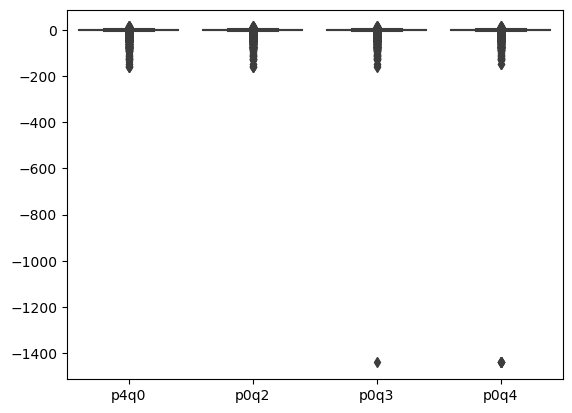

In [18]:
# Affichage de la distribution des variables quantitatives
sns.boxplot(data = X_train_quant_features)
plt.show()

On remarque à partir du boxplot qu'il n'y a que deux données qui semblent réellement sortir du lot : deux écarts entre temps d'attente prévu et réalisé de 1400 minutes. Ces outliers sont retirés du dataset d'entrainement contenant les features et la variable cible : 

In [19]:
# Nombre de lignes par colonnes <= 1400
print(X_train[X_train.p0q3 <= -1400].count())
print(X_train[X_train.p0q4 <= -1400].count())

train    1
gare     1
date     1
arret    1
p2q0     1
p3q0     1
p4q0     1
p0q2     1
p0q3     1
p0q4     1
dtype: int64
train    6
gare     6
date     6
arret    6
p2q0     6
p3q0     6
p4q0     6
p0q2     6
p0q3     6
p0q4     6
dtype: int64


In [20]:
# Liste d'indices contenant les valeurs extrêmes que l'on veut supprimer des dataframes d'entrainement
index_to_suppr: list = []
index_to_suppr.append(X_train.nsmallest(1, "p0q3").index.values.item())
index_to_suppr = index_to_suppr + X_train.nsmallest(6, "p0q4").index.values.tolist()# Suppression des lignes à -1441

X_train.drop(index_to_suppr, axis = 0, inplace=True)
X_train_quant_features.drop(index_to_suppr, axis = 0, inplace=True)
y_train.drop(index_to_suppr, axis = 0, inplace=True)

Les statistiques descriptives donnent désormais : 

In [21]:
round(X_train_quant_features.describe(),2)

,p4q0,p0q2,p0q3,p0q4
count,667257.00,667257.00,667257.00,667257.00
mean,-0.18,-0.16,-0.17,-0.16
std,1.93,1.99,1.97,1.94
min,-160.00,-160.00,-160.00,-149.00
25%,-1.00,-1.00,-1.00,-1.00
50%,0.00,0.00,0.00,0.00
75%,1.00,1.00,1.00,1.00
max,15.00,15.00,15.00,15.00


Il y'a désormais une plus grande homogénéité dans les données. Des retards de 160 minutes correspondent à des décalages de 2h40. Nous les conservons dans la base car ils ne sont pas significativement éloignés dans le boxplot. 

La prévision de temps d'attente sur-estime au plus le temps d'attnete de 15 minutes et la médiane est bien à 0 (= prévision correcte).

In [22]:
# Visualisation des statistiques sur les données groupées par gare (moyenne)
X_train.groupby('gare').mean()

,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4
gare,,,,,,,
ADU,33.397260,-0.232877,0.342466,0.219178,0.643836,0.630137,0.109589
ARX,20.630378,1.448827,-0.434627,-1.790996,-0.785106,-0.765331,-0.800884
AUW,17.069642,-0.654047,-1.201459,-0.242966,-0.079889,-0.084578,-0.065648
AVF,20.367081,0.290492,-0.049766,-0.314690,-0.467527,-0.486360,-0.475859
AVU,19.513434,-0.165435,-0.311979,-0.161563,-0.433885,-0.403144,-0.409715
...,...,...,...,...,...,...,...
YWQ,16.955834,-1.030082,-0.001043,-0.167101,0.119805,0.132499,0.119284
ZAL,27.682601,0.076626,0.406327,0.646397,0.254482,0.273111,0.278735
ZFB,15.799289,-0.183469,-0.579665,-0.417156,-0.544803,-0.517054,-0.503691


L'objectif de cette visualisation est de voir s'il y a des arrêts avec une différence généralement positive ou négative. Une différence négative indique que le temps d'attente est supérieur aux prévisions alors qu'une différence positive implique que le temps d'attente est inférieure aux prévisions.

On peut faire l'hypothèse que sur 8 mois, il y a certaines gares où les prévisions de temps d'attente sont trop faibles. Cela peut correspondre, par exemple, à des gares avec une forte affluence (gare importante en termes d'affluence, de correspondance, ...) où il est plus probable qu'il y ait un aléa (problème technique, accident voyageur, ... )

On peut ainsi distinguer deux cas :
- Les gares où p0q2, p0q3 et p0q4 sont en moyenne négative : il s'agit des gares où la propension de retards est plus importantes (1)
- Les autres gares (0)

Pour affiner l'analyse, nous tenons également compte des jours pour détecter une éventuelle saisonnalité :

In [23]:
# Moyenne par jour et par gare 
# --> Comparaison entre journées pour étudier une éventuelle saisonnalité
X_train_stop_day = X_train.groupby(['date','gare']).mean()
X_train_stop_day

arret      p2q0      p3q0      p4q0      p0q2      p0q3  \
date       gare                                                                
2023-04-03 ARX   20.530435  1.121739 -0.434783 -1.747826 -0.443478 -0.417391   
           AUW   16.283784 -0.243243 -0.986486  0.013514 -0.175676 -0.175676   
           AVF   19.981651  0.513761  0.256881  0.064220 -0.321101 -0.321101   
           AVU   19.093458  0.018692  0.093458  0.000000 -0.411215 -0.308411   
           AZA   16.383117  1.045455 -0.694805 -0.344156 -0.435065 -0.422078   
...                    ...       ...       ...       ...       ...       ...   
2023-11-10 YWQ   16.859649 -2.561404 -0.842105 -0.877193 -0.105263 -0.175439   
           ZAL   27.838710 -0.677419  0.193548  0.225806  0.548387  0.548387   
           ZFB   15.385000 -0.650000 -1.775000 -2.105000 -2.260000 -2.235000   
           ZHN   16.000000 -0.511551 -0.382838 -1.379538 -2.676568 -2.597360   
           ZVY   16.870504  0.251799  0.294964 -1.769784 -0.712230 -0.769784   

                     p0q4  
date       gare            
2023-04-03 ARX  -0.373913  
           AUW  -0.148649  
           AVF  -0.275229  
           AVU  -0.429907  
           AZA  -0.415584  
...                   ...  
2023-11-10 YWQ  -0.175439  
           ZAL   1.161290  
           ZFB  -2.220000  
           ZHN  -2.782178  
           ZVY  -0.697842  

[7066 rows x 7 columns]

In [24]:
# Visualisation pour une gare particulière - ARX
X_train_stop_day_ARX = X_train_stop_day[X_train_stop_day.index.get_level_values(1)=="ARX"]
X_train_stop_day_ARX.head()
print(X_train_stop_day_ARX.mean())

arret    20.538649
p2q0      1.431799
p3q0     -0.440313
p4q0     -1.778081
p0q2     -0.788660
p0q3     -0.769706
p0q4     -0.802970
dtype: float64


Nous observons que selon les jours, l'écart entre le temps d'attente prévu et réalisé au sein d'une même gare diffère. Intuitivement, on peut donc supposer qu'il existe une relation entre le jour de la semaine et la qualité des prévisions. En effet, les niveaux d'affluence ne sont par exemple pas les mêmes en fonction des jours. 

Typiquement, on peut s'attendre à ce qu'il y ait davantage de passagers, et donc de source de retard, les Mardi, Mercredi et Jeudi par rapport au Lundi et Vendredi qui sont des jours plus propices au télétravail. 

In [25]:
# Dictionnaire pour stocker les écarts moyens pour chaque gare 
dict_gare = {}
list_gare = X_train['gare'].unique()
for gare in list_gare:
    X_train_stop_day_gare = X_train_stop_day[X_train_stop_day.index.get_level_values(1)==gare]
    X_train_stop_day_gare = X_train_stop_day_gare.drop('arret', axis=1)
    print(X_train_stop_day_gare.head())
    print(f'Moyenne pour la gare {gare} : ', X_train_stop_day_gare.mean())
    
    # Stockage dans un dictionnaire
    dict_gare[gare] = X_train_stop_day_gare.mean().to_list()

                     p2q0      p3q0      p4q0      p0q2      p0q3      p0q4
date       gare                                                            
2023-04-03 KYF   0.353591 -0.212707  0.024862 -1.176796 -1.190608 -1.154696
2023-04-04 KYF   0.301493 -0.268657  0.044776 -1.379104 -1.373134 -1.382090
2023-04-05 KYF   0.157143 -0.191429  0.040000 -0.965714 -0.971429 -0.971429
2023-04-06 KYF   0.272358 -0.272358  0.012195 -1.085366 -1.069106 -1.069106
2023-04-07 KYF   0.263699 -0.304795  0.102740 -1.226027 -1.243151 -1.226027
Moyenne pour la gare KYF :  p2q0    0.393266
p3q0   -0.576870
p4q0   -0.383144
p0q2   -0.955808
p0q3   -0.958986
p0q4   -0.953399
dtype: float64
                     p2q0      p3q0      p4q0      p0q2      p0q3      p0q4
date       gare                                                            
2023-04-03 JLR  -0.375000 -0.028061 -0.214286  0.359694  0.375000  0.377551
2023-04-04 JLR  -0.608219 -0.043836 -0.164384  0.326027  0.309589  0.336986
2023-04-05 JLR  -0.

#### Corrélation entre les features et la cible (V de Cramer ou test Chi-deux ou kruskall-wallis selon si les features et la cible sont continues ou catégorielles)

Pour analyser les corrélations, nous conservons uniuqement les variables quantitatives continues dans un premier temps. Cela nous permet de réaliser une corrélation de Cramer : 

In [26]:
# Certaines features sont continues : temps d'attente
# Les autres sont catégorielles : k, s, d
# Dataframe contenant uniquement les features quantitatives
df_corr = pd.DataFrame()
df_corr['p0q0'] = y_train
for col in X_train_quant_features.columns:
    df_corr[col] = X_train_quant_features[col]

# Matrice de corrélarion
corr_features = df_corr.corr()
corr_features

,p0q0,p4q0,p0q2,p0q3,p0q4
p0q0,1.000000,0.039451,0.277716,0.208411,0.211032
p4q0,0.039451,1.000000,0.113608,0.128867,0.119876
p0q2,0.277716,0.113608,1.000000,0.259898,0.287357
p0q3,0.208411,0.128867,0.259898,1.000000,0.267768
p0q4,0.211032,0.119876,0.287357,0.267768,1.000000


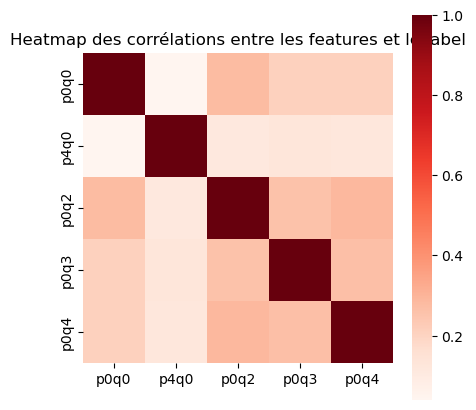

In [27]:
fig = plt.figure(figsize=(5,5))
sns.heatmap(corr_features, vmax = 1, square=True, cmap='Reds')
plt.title('Heatmap des corrélations entre les features et le label')
plt.show()

Pour analyser les corrélations avec l'ensemble des variables, il faut préalablement retraiter les variables catégorielles (= encodage) : 

## 4) Traitement et création de nouvelles features

### 4.1) Ajout de nouvelles features et création TRAIN et TEST

Sur la base de ce que nous avons observé sur le jeu de données, nous proposons d'ajouter les features suivantes :
- Le jour de la semaine pour tenir compte d'un effet saisonnier
- Le mois selon la même logique
- Une variable indicatrice pour détecter les gares de fortes affluences (= gares où en moyenne la prévision surestime le temps d'attente).

In [28]:
# Modification de la base pour inclure le jour et le mois
X_train['Mois'] = X_train['date'].dt.month
X_train['Jour'] = X_train['date'].dt.day_of_week
X_test['Mois'] = X_test['date'].dt.month
X_test['Jour'] = X_test['date'].dt.day_of_week
X_train

,train,gare,date,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4,Mois,Jour
0,VBXNMF,KYF,2023-04-03,8,0.0,0.0,1.0,-3.0,-1.0,-2.0,4,0
1,VBXNMF,JLR,2023-04-03,9,0.0,0.0,0.0,1.0,0.0,1.0,4,0
2,VBXNMF,EOH,2023-04-03,10,-1.0,0.0,0.0,-1.0,0.0,0.0,4,0
3,VBXNMF,VXY,2023-04-03,11,-1.0,-1.0,0.0,2.0,-2.0,0.0,4,0
4,VBXNMF,OCB,2023-04-03,12,-1.0,-1.0,-1.0,-1.0,3.0,2.0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
667259,BFNJJK,DGG,2023-11-10,22,0.0,-1.0,-6.0,-1.0,0.0,-2.0,11,4
667260,BFNJJK,KDN,2023-11-10,23,0.0,0.0,-1.0,1.0,0.0,0.0,11,4
667261,BFNJJK,TVD,2023-11-10,24,1.0,0.0,0.0,-1.0,-3.0,-1.0,11,4
667262,BFNJJK,TXP,2023-11-10,26,2.0,2.0,1.0,0.0,0.0,1.0,11,4


En termes de date, l'ajout de l'année semble peu pertinent dans la mesure où la période couverte par l'échantillon inclut uniquement l'année 2023. Inclure le mois associé à chaque date peut permettre d'étudier le présence d'un effet saisonnier d'un mois à l'autre. 

En outre, ajouter les jours permet de capter une partie de l'information liée à l'influence dans les gares (plus importantes en milieu de semaine qu'en début / fin de semaine) qui n'est pas fournie dans le dataset initial.

In [29]:
# Calcul de l'écart entre le temps d'attente prévu et réalisé par jour
X_train.groupby(['Jour']).mean()

,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4,Mois
Jour,,,,,,,,
0,18.313744,-0.158257,-0.153015,-0.159175,-0.148732,-0.156239,-0.146020,7.490033
1,18.347330,-0.171132,-0.166994,-0.179256,-0.157895,-0.169488,-0.158383,6.952270
2,18.332306,-0.153853,-0.150361,-0.158431,-0.150020,-0.155384,-0.150750,6.927815
3,18.276657,-0.193501,-0.192650,-0.198864,-0.184530,-0.194343,-0.180166,7.183333
4,18.109667,-0.177991,-0.174811,-0.186578,-0.176166,-0.182845,-0.172781,7.087761


On observe qu'en moyenne, le décalage entre le temps d'attente prévu / réalisé par jour est systématiquement négatif. Les valeurs de l'écart sont globalement proches en moyenne d'un jour à l'autre, ce qui limite la portée que pourrait avor une telle variable dans la suite de notre analyse.

In [30]:
X_train.groupby(['Mois']).mean()

,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4,Jour
Mois,,,,,,,,
4,18.292383,-0.096764,-0.095881,-0.102057,-0.094589,-0.101431,-0.091594,1.975186
5,18.205419,-0.161898,-0.157410,-0.160391,-0.139658,-0.150973,-0.137223,1.958169
6,18.334353,-0.184638,-0.184931,-0.199756,-0.180987,-0.189070,-0.180444,2.182432
9,18.405293,-0.198577,-0.194615,-0.205559,-0.195474,-0.203509,-0.192045,1.996419
10,18.107448,-0.152646,-0.145118,-0.151445,-0.144453,-0.152461,-0.145062,1.862863
11,18.211570,-0.273133,-0.264774,-0.274459,-0.265968,-0.269816,-0.264296,1.955924


On observe de la variabilité au niveau des écarts entre les moyennes des écarts temps d'attente prévu / réalisé entre les différents mois. En particulier, les écarts en septembre et novembre sont plus importants qu'en avril et octobre. 

In [31]:
# Récupération d'une indicatrice qui mesure la "proba de retard" associée à chaque date
gare = X_train[['gare', 'p2q0', 'p3q0', 'p4q0']].groupby('gare').mean()
gare['indic'] = np.zeros(gare.shape[0])
for i in range(gare.shape[0]):
    if gare.iloc[i, 0] < 0 and gare.iloc[i, 1] < 0 and gare.iloc[i, 2] < 0:
        gare.iloc[i, 3] = 1
gare.drop(['p2q0', 'p3q0','p4q0'], axis = 1, inplace = True)
gare.rename(columns = {'indic':'prob delay'}, inplace = True)
gare

,prob delay
gare,
ADU,0.0
ARX,0.0
AUW,1.0
AVF,0.0
AVU,1.0
...,...
YWQ,1.0
ZAL,0.0
ZFB,1.0


In [32]:
# Merge des dataframes
X_train = X_train.merge(right = gare, how = 'left', on="gare")
X_test = X_test.merge(right = gare, how = 'left', on="gare")

### 4.3) Traitement des valeurs manquantes (Imputation)

In [33]:
# Nombre de données manquantes au sein des deux dataset
print('Nombre de données manquantes sur le train set : ', X_train.isna().sum())
print('Nombre de données manquantes sur le train set y : ', y_train.isna().sum())
print('Nombre de données manquantes sur le test set : ', X_test.isna().sum())

Nombre de données manquantes sur le train set :  train         0
gare          0
date          0
arret         0
p2q0          0
p3q0          0
p4q0          0
p0q2          0
p0q3          0
p0q4          0
Mois          0
Jour          0
prob delay    0
dtype: int64
Nombre de données manquantes sur le train set y :  p0q0    0
dtype: int64
Nombre de données manquantes sur le test set :  train         0
gare          0
date          0
arret         0
p2q0          0
p3q0          0
p4q0          0
p0q2          0
p0q3          0
p0q4          0
Mois          0
Jour          0
prob delay    0
dtype: int64


Il n'y a pas de valeurs manquantes dans la base initiale. Il n'est donc pas nécessaire de retraiter les données.

### 4.4) Rééquilibrage de la base si besoin

Pour vérifier si la base a besoin d'être rééquilibrée, on peut regarder la proportion de prévision correcte par rapport aux retards / avances. S'il y'a une différence entre les proportions dans notre base d'entrainement et de test, nous rééquilibrerons :  

In [34]:
# Sur le dataset d'entrainement
print('Répartition sur le dataset d entrainement')
for i in range(4, 10):
    print(f'Informations sur la répartition des prévisions pour la colonne {X_train.columns[i]}')
    serie: pd.Series = X_train[X_train.columns[i]]
    print(f'Part de prévisions correctes : {round(serie[serie == 0].count() / X_train.shape[0],2)}')
    print(f'Part de retards dans l échantillon : {round(serie[serie < 0].count() / X_train.shape[0], 2)}')
    print(f'Part de retards dans l échantillon : {round(serie[serie > 0].count() / X_train.shape[0], 2)}')
    print('')

# Sur le dataset de test
print('Répartition sur le dataset de test')
for i in range(4, 10):
    print(f'Informations sur la répartition des prévisions pour la colonne {X_test.columns[i]}')
    serie: pd.Series = X_test[X_test.columns[i]]
    print(f'Part de prévisions correctes : {round(serie[serie == 0].count() / X_test.shape[0],2)}')
    print(f'Part de retards dans l échantillon : {round(serie[serie < 0].count() / X_test.shape[0], 2)}')
    print(f'Part de retards dans l échantillon : {round(serie[serie > 0].count() / X_test.shape[0], 2)}')
    print('')

Répartition sur le dataset d entrainement
Informations sur la répartition des prévisions pour la colonne p2q0
Part de prévisions correctes : 0.44
Part de retards dans l échantillon : 0.29
Part de retards dans l échantillon : 0.27

Informations sur la répartition des prévisions pour la colonne p3q0
Part de prévisions correctes : 0.44
Part de retards dans l échantillon : 0.29
Part de retards dans l échantillon : 0.27

Informations sur la répartition des prévisions pour la colonne p4q0
Part de prévisions correctes : 0.44
Part de retards dans l échantillon : 0.3
Part de retards dans l échantillon : 0.27

Informations sur la répartition des prévisions pour la colonne p0q2
Part de prévisions correctes : 0.43
Part de retards dans l échantillon : 0.29
Part de retards dans l échantillon : 0.28

Informations sur la répartition des prévisions pour la colonne p0q3
Part de prévisions correctes : 0.43
Part de retards dans l échantillon : 0.29
Part de retards dans l échantillon : 0.27

Informations s

Au terme de cette analyse, nous observons qu'il y a dans la base :
- environ 40% de prévisions correctes
- autour de 33% de prévisions de temps d'attente trop faibles par rapport au temps d'attente réalisé (retards)
- autour de 27% de prévisions de temps d'attente trop élevé par rapport au temps d'attente réalisé (avance)

Ces proportions sont similaires entre nos deux datasets. Un rééquilibrage de la base ne semble donc pas nécessaire.

### 4.5) Encodage des données

In [35]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_train['train'] = le.fit_transform(X_train['train'])
X_train['gare'] = le.fit_transform(X_train['gare'])
X_train['date'] = le.fit_transform(X_train['date'])
X_test['train'] = le.fit_transform(X_test['train'])
X_test['gare'] = le.fit_transform(X_test['gare'])
X_test['date'] = le.fit_transform(X_test['date'])
X_train

,train,gare,date,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4,Mois,Jour,prob delay
0,30536,34,0,8,0.0,0.0,1.0,-3.0,-1.0,-2.0,4,0,0.0
1,30536,26,0,9,0.0,0.0,0.0,1.0,0.0,1.0,4,0,1.0
2,30536,14,0,10,-1.0,0.0,0.0,-1.0,0.0,0.0,4,0,1.0
3,30536,68,0,11,-1.0,-1.0,0.0,2.0,-2.0,0.0,4,0,1.0
4,30536,43,0,12,-1.0,-1.0,-1.0,-1.0,3.0,2.0,4,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
667252,1767,10,90,22,0.0,-1.0,-6.0,-1.0,0.0,-2.0,11,4,0.0
667253,1767,31,90,23,0.0,0.0,-1.0,1.0,0.0,0.0,11,4,0.0
667254,1767,61,90,24,1.0,0.0,0.0,-1.0,-3.0,-1.0,11,4,0.0
667255,1767,62,90,26,2.0,2.0,1.0,0.0,0.0,1.0,11,4,0.0


A la suite de l'encodage des variables catégorielles, on peut désormais étudier la corrélation entre nos variables qualitatives et notre variable cible : 

In [36]:
cols_categorical = [0, 1, 2, 3, 10, 11, 12]
X_train_categorical:pd.DataFrame = X_train.iloc[:,cols_categorical]
X_train_categorical
# Test de Kruskal Wallis
kstat, pval = scipy.stats.kruskal(y_train, X_train_categorical)
print(pval)

[0. 0. 0. 0. 0. 0. 0.]


Les résultats de ces tests sont des p-values très faibles. En dehors de la seconde variable qui semble significative au seuil de 5%, nous rejetons systématiquement l'hypothèse nulle. A revoir (test et interprétation).


Dans les jeux de données fournis, le site du challenge précise que le dataset y_sample contient "des valeurs aléatoires entre -10 et 10. Ce jeu est donc visiblement fourni avant tout à titre d'exemple pour comprendre le format à retourner. Nous allons donc séparer notre échantillon en deux ensembles : entrainement et validation pour réaliser nos tests : 

### 4.6) Normalisation des données

Pour normaliser les données, nous procédons à une standardisation. Ce choix, par rapport à la normalisation, s'explique par le fait que centrer et réduire implique d'avoir de la stationnarité pour nos variables temporelles. Or, cette stationnarité n'est pas garantie. Nous privilégions donc la standardisation.

In [37]:

def scaling(df, list_features):
    # Fonction permettant de standardiser les features quantitatives sur le dataframe
    # Input : DataFrame dont on veut scaler les données
    # Output : DataFrame d'entrées avec données scaled, liste contenant les valeurs minimales et maximales utilisées 
    # pour chaque features

    # Création du dataframe que l'on renverra une fois traité
    df_res = df.copy()

    # Liste pour récupérer les valeurs min et max
    list_min = []
    list_max = []

    # Boucle sur les features à standardiser
    for feature in list_features:
        vmin = df_res[feature].min()
        vmax = df_res[feature].max()
        # Ajout aux listes
        list_min.append(vmin)
        list_max.append(vmax)

        # Standardisation
        df_res[feature] = (df_res[feature] - vmin)/(vmax - vmin)

    # Modifie également df ? 
    return df_res, list_min, list_max


In [38]:
list_features = X_train.columns.to_list()
X_train, list_min, list_max = scaling(X_train, list_features)
X_train.head()

,train,gare,date,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4,Mois,Jour,prob delay
0,0.813361,0.409639,0.0,0.028571,0.919540,0.914286,0.920000,0.897143,0.908571,0.896341,0.0,0.0,0.0
1,0.813361,0.313253,0.0,0.057143,0.919540,0.914286,0.914286,0.920000,0.914286,0.914634,0.0,0.0,1.0
2,0.813361,0.168675,0.0,0.085714,0.913793,0.914286,0.914286,0.908571,0.914286,0.908537,0.0,0.0,1.0
3,0.813361,0.819277,0.0,0.114286,0.913793,0.908571,0.914286,0.925714,0.902857,0.908537,0.0,0.0,1.0
4,0.813361,0.518072,0.0,0.142857,0.913793,0.908571,0.908571,0.908571,0.931429,0.920732,0.0,0.0,1.0


In [39]:
# Transformation du dateset de test avec les valeurs trouvées sur le dataset d'entrainement
for j in range(0, len(list_features)-1):
    feature = list_features[j]
    X_test[feature] = (X_test[feature] - list_min[j])/(list_max[j]-list_min[j])
X_test


,train,gare,date,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4,Mois,Jour,prob delay
0,0.211091,0.783133,0.000000,0.142857,0.919540,0.914286,0.902857,0.891429,0.902857,0.884146,1.000000,0.0,1.0
1,0.085981,0.783133,0.000000,0.142857,0.919540,0.914286,0.908571,0.920000,0.908571,0.908537,1.000000,0.0,1.0
2,0.135684,0.783133,0.000000,0.142857,0.919540,0.920000,0.908571,0.920000,0.908571,0.914634,1.000000,0.0,1.0
3,0.048877,0.783133,0.000000,0.142857,0.919540,0.914286,0.908571,0.908571,0.914286,0.902439,1.000000,0.0,1.0
4,0.057507,0.060241,0.000000,0.142857,0.925287,0.902857,0.914286,0.914286,0.914286,0.908537,1.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20652,0.057934,0.518072,0.255556,0.485714,0.913793,0.908571,0.920000,0.914286,0.920000,0.908537,1.142857,1.0,0.0
20653,0.031670,0.373494,0.255556,0.142857,0.919540,0.914286,0.914286,0.914286,0.914286,0.908537,1.142857,1.0,1.0
20654,0.031670,0.349398,0.255556,0.314286,0.925287,0.902857,0.914286,0.908571,0.908571,0.896341,1.142857,1.0,1.0
20655,0.031670,0.518072,0.255556,0.485714,0.908046,0.902857,0.920000,0.914286,0.914286,0.914634,1.142857,1.0,0.0


In [40]:
# Création d'un échantillon de train et de validation pour réaliser des tests sur nos modèles
from sklearn.model_selection import train_test_split
X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)

In [41]:
y_val

,p0q0
533812,1.0
533813,0.0
533814,0.0
533815,1.0
533816,1.0
...,...
667259,1.0
667260,2.0
667261,2.0
667262,1.0


Au terme de la phase exploratoire, nous avons sélectionné et retraité les features que nous souhaitons utiliser pour entraîner notre modèle. 



## 5) Benchmark

La première étape avant de passer à l'estimation des modèles est de construire le benchmark. Pour ce challenge, le benchmark à utiliser est imposé. Il s'agit d'un modèle de forêt aléatoire classique qui utilise la MAE comme mesure de performance.

Pour estimer la performance de notre benchmark, nous entrainons donc un modèle de forêt aléatoire sur notre dataset d'entrainement et testons sur le dataset de validation. Afin de rester dans une référence simple, nous n'optimisons pas les hyperparamètres de cette forêt aléatoire. 

##### **Création et Entrainement du modèle**

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Instanciation d'un modèle de forêt aléatoire
benchmark = RandomForestRegressor()

# Estimation du modèle
benchmark.fit(X_train_val, np.array(y_train_val))

# Prévision et calcul des métriques de performances
y_pred = benchmark.predict(X_val)
mae_bench = mean_absolute_error(y_val, y_pred=y_pred)
r2_bench = r2_score(y_val, y_pred)
print(f'Performance du benchmark : {mae_bench}')
print(f'R2 du benchmark : {r2_bench}')

/Users/timotheedangleterre/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Performance du benchmark : 0.9104470521236101
R2 du benchmark : -0.20502886131770737


R2 étonnant ...

Le résultat avec le benchmark du challenge sur notre dataset d'entrainement, comparé avec le dataset de validation, est de 0,9112. Il est légèrement plus élevé que la valeur donnée en référence sur le site du challenge (0,8930). Cette différence peut s'expliquer par la présence des features que nous avons ajouté (jour, mois, indicatrice). L'ajout de ces features qui présentait un intérêt intuitivement pour capter l'effet saisonnier et l'affluence des gares pourrait donc in fine se réveler pénalisant. 

Ce modèle de forêt aléatoire sans optimisation d'hyperparamètres sera donc notre benchmark pour la suite de notre étude. Nous pourrons essayer de l'optimiser dans un second temps. 

Après soumission, nous obtenons une MAE de ...

## 6) Modèle non supervisé 

L'utilisation d'une méthode d'apprenstissage non supervisée peut être utile pour explorer ou prétraiter les données. 

### 6.1) ACP

Compte tenu de notre problème, nous pourrions songer à utiliser l'ACP pour synthétiser certaines de nos variables. En effet, ce problème de régression est un problème "en forme de L". Il y a en effet 2 aspects centraux :
- Le décalage temps d'attente prévu - temps d'attente réalisé pour les trains précédents à la gare s ;
- Le décalage temps d'attente prévu - temps d'attente réalisé pour le train k aux gares précédents ;

Une ACP pourrait donc permettre de réduire la dimensionnalité de nos données. Il n'est en revanche pas sur qu'elle soit pertinente pour synthétiser le reste de nos features, dans la mesure où les données sont assez dictinctes (données temporelles, données spatiales, ...).

In [43]:
from sklearn.decomposition import PCA 
methods = [("Stardard",X_train_val,y_train_val,X_val)]

Methode 1
Variance expliquée : [0.3440551  0.52435417 0.6940182  0.81811563 0.93686633 0.99345023
 0.99894941 0.99926625 0.99949541 0.99967488 0.99980884 0.99993854
 1.        ]


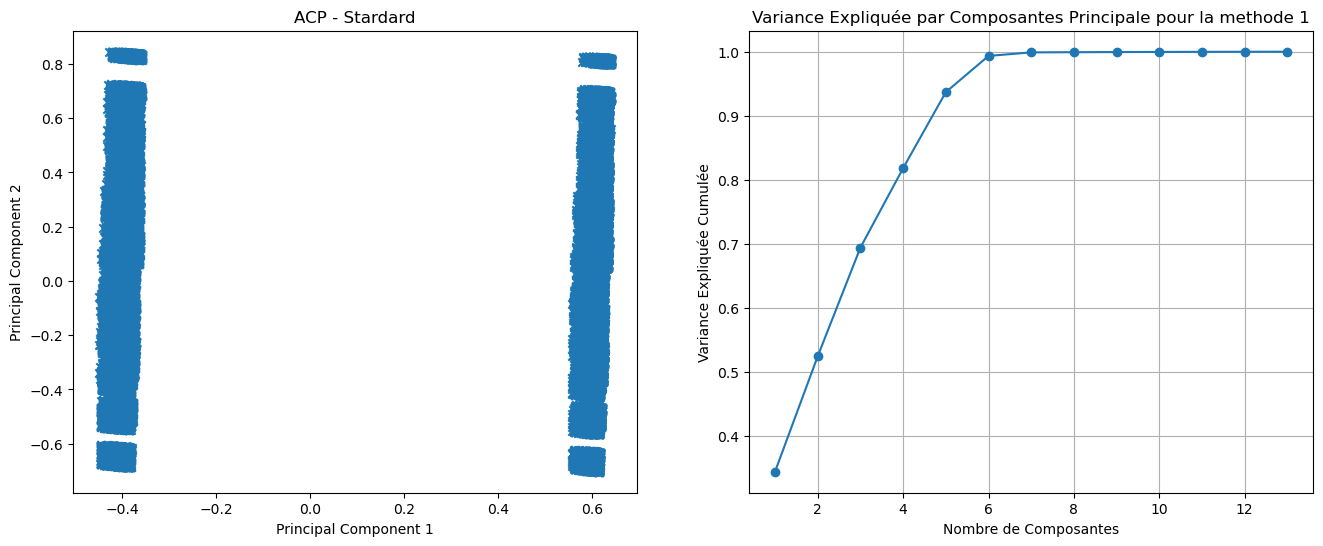

In [44]:
result_kmeans = []
for i,method in enumerate(methods):
    nom,X_train_method,y_train_method,X_test_method=method
    
    # PCA pour la réduction de dimensions
    pca = PCA() #Pour affichage graphique
    x_train_pca = pca.fit_transform(X_train_method)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    print(f"Methode {i+1}\nVariance expliquée : {cumulative_variance}")

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    # Visualisation des clusters
    axes[0].scatter(x=x_train_pca[:, 0], y=x_train_pca[:, 1],marker="x")
    axes[0].set_title(f"ACP - {nom}")
    axes[0].set_xlabel('Principal Component 1')
    axes[0].set_ylabel('Principal Component 2')

    # Visualisation de l'évolution de la variance
    axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    axes[1].set_xlabel('Nombre de Composantes')
    axes[1].set_ylabel('Variance Expliquée Cumulée')
    axes[1].set_title(f'Variance Expliquée par Composantes Principale pour la methode {i+1}')
    axes[1].grid(True)
    plt.show()
   

Le résultat de l'ACP montre qu'il faudrait conserver 6 composantes pour expliquer 95% de la variance expliquée. Cela réduirait ainsi de moitié le nombre de features dans notre dataset. 

Le nombre de composantes principales à retenir est élevé, ce qui peut indiquer que cette méthode n'est pas forcément la plus adaptée pour répondre à notre problème. Nous essayons tout de même d'estimer un k-means pour voir si ce dernier améliore nos prévisions :

### 6.2) Kmeans

#### 6.2.1) Ajout de Features

Nous allons utiliser un kmeans pour regrouper nos données en cluster et leur ajouter des données qui pourraient être utiles dans notre analyse. Nous pouvons ajouter des valeurs sur les centres de gravité de nos données, ou sur des moyennes des valeur de nos cluster comme celle du *predicted_spot_price*. Nous allons donc génerer ces deux features et tester ces nouvelles méthodes de données dans la suite de notre travail. 

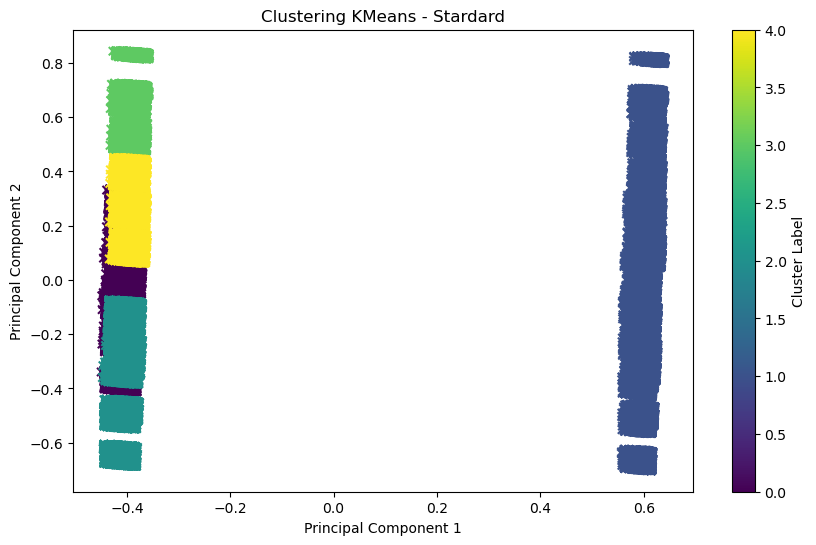

In [45]:
from sklearn.cluster import KMeans
methods_features=[]
for i,method in enumerate(methods):
    nom,X_train_method,y_train_method,X_test_method=method
    # PCA pour la réduction de dimensions
    pca = PCA()
    x_train_pca = pca.fit_transform(X_train_method)
    x_test_pca = pca.transform(X_test_method)

    # KMeans Clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(x_train_pca)
    clusters = kmeans.predict(x_train_pca)
    clusters_test = kmeans.predict(x_test_pca)

    # Visualisation des clusters
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(x=x_train_pca[:, 0], y=x_train_pca[:, 1], c=clusters, marker= 'x', cmap='viridis')
    plt.title(f"Clustering KMeans - {nom}")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter, label='Cluster Label')
    plt.show()

    # ajout des centroids et cluster aux données existantes
    x_train_pca = pd.DataFrame(x_train_pca,index=X_train_method.index)
    x_test_pca = pd.DataFrame(x_test_pca,index=X_test_method.index)
    clusters = pd.DataFrame(clusters,index=X_train_method.index,columns=['cluster'])
    clusters_test = pd.DataFrame(clusters_test,index=X_test_method.index,columns=['cluster'])
    centroids = kmeans.cluster_centers_
    for i,c in enumerate(centroids) :
        for j in range(len(c)):
            clusters.loc[clusters.cluster==i,f'cluster_{j}'] = c[j]
            clusters_test.loc[clusters_test.cluster==i,f'cluster_{j}'] = c[j]
    data_cluster = pd.concat([X_train_method,clusters],axis=1)
    data_cluster_test = pd.concat([X_test_method,clusters_test],axis=1)
    methods_features.append(('Cluster',data_cluster,y_train_method,data_cluster_test))

    methods = methods + methods_features


##### **Etudes de nouvelles données**

Pour les deux premières methodes, les nouvelles données sont très peu corrélée avec la variable cible. Mais pour notre méthode 3, les données sont un peu plus corrélées et apportent des informations supplémentaire. Nous les garderons donc pour nos prévisions.

#### 6.2.2) Prediction après clustering

Nous allons utiliser un Kmeans pour faire une prédictions de notre variable cible.

In [46]:
result_kmeans = []
for i,method in enumerate(methods):
    nom,X_train_method,y_train_method,X_test_method=method
    # PCA pour la réduction de dimensions
    pca = PCA()
    x_train_pca = pca.fit_transform(X_train_method)
    x_train_pca = pd.DataFrame(x_train_pca,index=X_train_method.index)

    # KMeans Clustering
    kmeans = KMeans(n_clusters=20, random_state=42)
    kmeans.fit(x_train_pca)
    x_train_pca['cluster'] = kmeans.predict(x_train_pca)

    # Compute y_pred as means of cluster for training
    x_train_pca = pd.concat([x_train_pca,y_train_method],axis=1)
    groups = x_train_pca.groupby(by='cluster')
    map_y = {}
    for nb,group in groups:
        print(group)
        map_y[nb] = group.p0q0.mean()
    x_train_pca['y_pred'] = x_train_pca['cluster'].apply(lambda x : map_y[x])

    # compute metrics
    mae = mean_absolute_error(y_train_method["p0q0"],x_train_pca['y_pred'])
    result_kmeans.append([f"Methode_{nom}",20,mae,kmeans,map_y,pca])
result_kmeans=pd.DataFrame(result_kmeans,columns=['Methode','nb_composante','mae','Model','Map','PCA'])

               0         1         2         3         4         5         6  \
25     -0.380151 -0.133462 -0.702049  0.421999 -0.208004 -0.320587 -0.076743   
27     -0.383406 -0.133244 -0.702922  0.494489 -0.208693 -0.263926 -0.076799   
29     -0.389744 -0.131345 -0.698587  0.205596 -0.206815 -0.205905 -0.077059   
31     -0.391321 -0.132122 -0.702440  0.482884 -0.208957 -0.149848 -0.077074   
39     -0.409844 -0.128322 -0.696761  0.134453 -0.207176  0.079347 -0.077738   
...          ...       ...       ...       ...       ...       ...       ...   
362144 -0.383346  0.037501  0.041277  0.276428 -0.345161 -0.151977  0.133849   
362151 -0.397134  0.038630  0.038774  0.494137 -0.347401  0.075253  0.133450   
362157 -0.410958  0.041433  0.042900  0.241850 -0.346129  0.247113  0.132945   
362159 -0.371015  0.032763  0.043901  0.359089 -0.489296 -0.323749  0.134409   
362170 -0.397237  0.035886  0.043077  0.493178 -0.491459  0.074821  0.133558   

               7         8         9   

KeyError: nan

In [48]:
result_kmeans

,Methode,nb_composante,W_Accuracy,Model,Map,PCA
0,Methode_Stardard,20,0.726275,"KMeans(n_clusters=20, random_state=42)","{0: 3.9913294888037805, 1: -0.7806099581360444...",PCA()
1,Methode_Cluster,20,0.687634,"KMeans(n_clusters=20, random_state=42)","{0: 5.090235310922655, 1: 3.894772512485785, 2...",PCA()
2,Methode_Mean,20,0.705436,"KMeans(n_clusters=20, random_state=42)","{0: 6.7500641879977845, 1: -1.2124675125855495...",PCA()


##### **Optimisation**

La methode 3 est celle qui à la weighted accuracy la plus importante. Nous allons donc essayer d'optimiser notre modèle avec ce set de données. Commençons par chercher le nombre de cluster idéal.

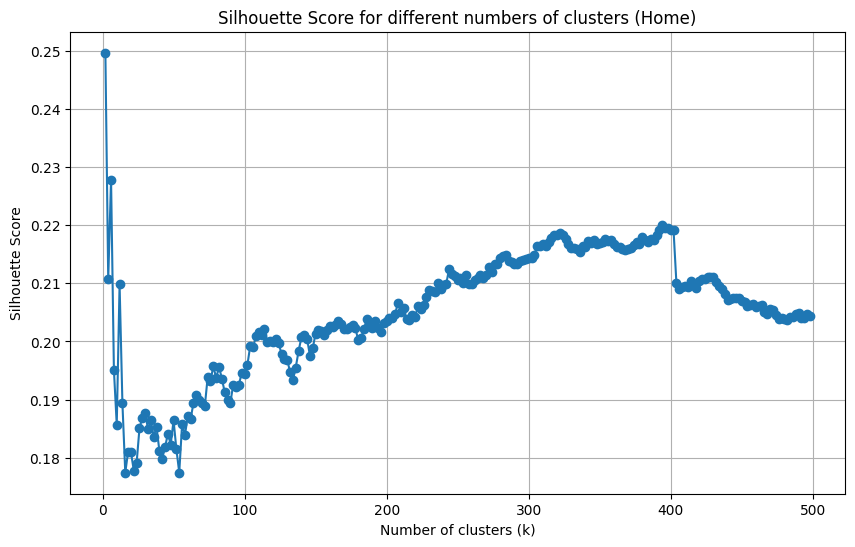

Meilleur nb de cluster : 2  pour un score de  0.24964557736219695


In [49]:
from sklearn.metrics import silhouette_score
# Fonction pour calculer le score de silhouette pour un nombre de clusters donné
def compute_silhouette_score(k, data):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    score = silhouette_score(data, cluster_labels)
    return score

score_sil = []
kmax = 500
for k in range(2, kmax,2):
    result = compute_silhouette_score(k, X_train_3)
    score_sil.append(result)


# Afficher les scores de silhouette
#k_values, silhouette_scores_home = zip(*[(result[0], result[1]) for result in score_sil])
plt.figure(figsize=(10, 6))
plt.plot([k for k in range(2, kmax,2)],score_sil, marker='o')
plt.title('Silhouette Score for different numbers of clusters (Home)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Extraire les meilleurs résultats
score = max(score_sil)
k_ideal = score_sil.index(score) +2
print(f"Meilleur nb de cluster :",k_ideal," pour un score de ",score)


Le score de silhouette nous donne 2 comme nombre de cluster idéal. Cependant, pour le bien de la prediction, nous allons en prendre plus et vérifier si les performances sont meilleures.

In [50]:
# PCA pour la réduction de dimensions
pca = PCA()
x_train_pca = pca.fit_transform(X_train_3)
x_train_pca = pd.DataFrame(x_train_pca,index=X_train_3.index)

# KMeans Clustering
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(x_train_pca)
x_train_pca['cluster'] = kmeans.predict(x_train_pca)

# Compute y_pred as means of cluster for training
x_train_pca = pd.concat([x_train_pca,y_train_3],axis=1)
groups = x_train_pca.groupby(by='cluster')
map_y = {}
for nb,group in groups:
    map_y[nb] = group.cible.mean()
x_train_pca['y_pred'] = x_train_pca['cluster'].apply(lambda x : map_y[x])

# compute metrics
w_acc = mean_absolute_error(y_train_3["cible"],x_train_pca['y_pred'])
comparaison.append([f"Methode_{nom}","Kmeans",w_acc])
w_acc

0.7396118154884794

Nous obtenons bien une meilleure performance en prédiction, donc nous retenons ce modèle.

##### **Prediction du *cible***

In [ ]:
model = kmeans
X_test_Kmeans = X_test_3.copy()
X_test_Kmeans = pd.DataFrame(pca.transform(X_test_Kmeans),index=X_test_Kmeans.index)
X_test_Kmeans['cluster'] = kmeans.predict(X_test_Kmeans)
X_test_Kmeans['cible'] = X_test_Kmeans['cluster'].apply(lambda x : map_y[x])
y_test_Kmeans = X_test_Kmeans[['cible']]
y_test_Kmeans

In [52]:
y_test_Kmeans.to_csv('y_test_Kmeans.csv')

Après soummission, nous obtenons une weighted accuracy de 0,5209416312886466.

## 7) Modèle supervisé 

### 7.1) Régression

Compte tenu de la nature de notre problème, les modèles supervisés que nous allons d'abord chercher à estimer sont des modèles de régression. Il convient dans un premier temps de modéliser les modèles les plus simples pour voir comment ces derniers se comportent. C'est pourquoi, nous allons estimer :
- Une régression linéaire
- Une régression linéaire pénalisée

##### **Selection des modèles**

In [47]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import pandas as pd

result_supervised = []
for i,method in enumerate(methods):
    # Split
    nom,X_train_method,y_train_method,X_test_method=method
    X_train_method_train, X_train_method_test, y_train_method_train, y_train_method_test = sk.model_selection.train_test_split(X_train_method, y_train_method, test_size=0.2, random_state=42)

    # LinearRegression
    lin_model = LinearRegression()
    lin_model.fit(X_train_method_train, y_train_method_train)
    y_pred_lin = lin_model.predict(X_train_method_test)
    mae_lin = mean_absolute_error(y_train_method_test, y_pred_lin)
    result_supervised.append((f"Methode_{nom}","Linear",mae_lin, lin_model))

    # Ridge
    ridge_model = Ridge(alpha=0.1,random_state=42)
    ridge_model.fit(X_train_method_train, y_train_method_train)
    y_pred_ridge = ridge_model.predict(X_train_method_test)
    mae_ridge = mean_absolute_error(y_train_method_test, y_pred_ridge)
    result_supervised.append((f"Methode_{nom}","ridge",mae_ridge, ridge_model))

    # Lasso
    lasso_model = Lasso(alpha=0.1,random_state=42)
    lasso_model.fit(X_train_method_train, y_train_method_train)
    y_pred_lasso = lasso_model.predict(X_train_method_test)
    mae_lasso = mean_absolute_error(y_train_method_test, y_pred_lasso)
    result_supervised.append((f"Methode_{nom}","lasso",mae_lasso, lasso_model))

    # SVR
    # svr_model = SVR()
    # svr_model.fit(X_train_method_train, y_train_method_train)
    # y_pred_svr = svr_model.predict(X_train_method_test)
    # mae_svr = mean_absolute_error(y_train_method_test['p0q0'], y_pred_svr)
    # result_supervised.append((f"Methode_{nom}","SVR",mae_svr,svr_model))



In [48]:
result_supervised

[('Methode_Stardard', 'Linear', 0.8719320228986589, LinearRegression()),
 ('Methode_Stardard',
  'ridge',
  0.8719513751968515,
  Ridge(alpha=0.1, random_state=42)),
 ('Methode_Stardard',
  'lasso',
  0.9618596908122005,
  Lasso(alpha=0.1, random_state=42)),
 ('Methode_Cluster', 'Linear', 0.8719683243286149, LinearRegression()),
 ('Methode_Cluster',
  'ridge',
  0.8719875298049562,
  Ridge(alpha=0.1, random_state=42)),
 ('Methode_Cluster',
  'lasso',
  0.9618596908122005,
  Lasso(alpha=0.1, random_state=42))]

Les performances de la régression linéaire et de la régression pénalisée sont très proches. Le modèle LASSO fournit des résultats plus dégradés, inférieurs au benchmark. On le retire donc de notre univers.  

Nous conservons la régression ridge que nous allons essayer d'optimiser


### 7.2) Optimisation des hyperparamètres de la régression linéaire

In [49]:
# Optimisation des hyperparamètres d'un modèle de régression 
from sklearn.model_selection import GridSearchCV
params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100], 
    'fit_intercept': [True, False]
}

grid_search = GridSearchCV(estimator=Ridge(), param_grid=params, verbose=0)
grid_search.fit(X_train_val, y_train_val.astype(int))
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)

Meilleurs paramètres trouvés :  {'alpha': 0.001, 'fit_intercept': True}


In [50]:
model_ridge = grid_search.best_estimator_
pred = model_ridge.predict(X_val)
mae = mean_absolute_error(y_val, pred)
#comparaison.append([f"Methode_{nom}","Ridge Regression",mae])
mae

# Cross - Validation

0.8584871838422936

##### **Prediction sur nos données X_test**

In [51]:
y_test_final = model_ridge.predict(X_test)
y_test_final = pd.DataFrame(y_test_final,index=X_test.index,columns=["p0q0"])
y_test_final.to_csv("y_ridge_reg.csv")

### 7.3) Modèle d'ensemble

Après avoir testé plusieurs modèles de régression, nous allons estimer un modèle d'ensemble. Etant donné que notre problème est un problème de régression, nous allons estimer un modèle GradientBoost

**Ajustement des données**

In [52]:
nom = "Standard"
X_train_method_train, X_train_method_test, y_train_method_train, y_train_method_test = sk.model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=42)
y_train_method_train = np.clip(y_train_method_train.astype(int), 0, 5)


**Creation du modèle**



In [69]:
from sklearn.ensemble import BaggingRegressor
# Estimation d'un modèle de Bagging avec comme estimateur de base des arbres de régression
model_bagging = BaggingRegressor(n_estimators=10, random_state=0).fit(X_train_method_train, np.ravel(y_train_method_train))

# Fit des données
model_bagging.fit(X_train_method_train, y_train_method_train)
y_pred_bagging = model_bagging.predict(X_train_method_test)
mae_bagging = mean_absolute_error(y_train_method_test, y_pred_bagging)
result_supervised.append((f"Methode_{nom}","bagging",mae_bagging, model_bagging))


/Users/timotheedangleterre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


In [81]:
# Définition de l'espace des hyperparamètres à observer
params = {
    'n_estimators': [10, 50, 100, 200],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0],
    }

# Recherche d'hyperparamètres avec validation croisée
grid_search_bagging: GridSearchCV = GridSearchCV(estimator = BaggingRegressor(), param_grid=params, verbose = 0)
grid_search_bagging.fit(X_train_method_train, np.ravel(y_train_method_train))
print("Meilleurs hyperparamètres : ", grid_search_bagging.best_params_)

KeyboardInterrupt: 

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

# Définir les modèles individuels
model1 = Ridge(alpha=0.01)
model2 = RandomForestRegressor(100, random_state=42)
model3 = LinearRegression()

# Créer le VotingClassifier
voting_hard = VotingClassifier(estimators=[('lr', model1), ('rf', model2), ('knn', model3)], voting='hard')
voting_soft = VotingClassifier(estimators=[('lr', model1), ('rf', model2), ('knn', model3)], voting='soft')

**Optimisation des hyperparamètre**

In [111]:
from sklearn.model_selection import GridSearchCV
# Définir l'espace des hyperparamètres à explorer
param_grid = {
    'lr__C': [0.1, 1, 10],             
    'rf__n_estimators': [50, 100, 200], 
    'rf__max_depth': [None, 10, 20],    
    'knn__n_neighbors': [3, 5, 7],      
    'knn__weights': ['uniform', 'distance'] 
}

# Recherche d'hyperparamètres avec validation croisée
grid_search_hard = GridSearchCV(estimator=voting_hard, param_grid=param_grid, scoring=mean_absolute_error, cv=5)
grid_search_hard.fit(X_train_method_train, np.ravel(y_train_method_train))

grid_search_soft = GridSearchCV(estimator=voting_hard, param_grid=param_grid,scoring=mean_absolute_error, cv=5)
grid_search_soft.fit(X_train_method_train, np.ravel(y_train_method_train))

# Afficher les meilleurs hyperparamètres et la meilleure précision
print("Meilleurs hyperparamètres hard:", grid_search_hard.best_params_)
print("Meilleurs hyperparamètres hard:", grid_search_soft.best_params_)

/Users/timotheedangleterre/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyboardInterrupt: 

In [94]:
model_soft = grid_search_soft.best_estimator_
model_hard = grid_search_hard.best_estimator_

In [96]:
# Prediction avec le VotingClassifier
y_pred_hard = model_soft.predict(X_train_method_test)
y_pred_soft = model_hard.predict(X_train_method_test)

# Calculer Metrique
accuracy_soft = mean_absolute_error(y_train_method_test['cible'], y_pred_soft)
accuracy_hard = mean_absolute_error(y_train_method_test['cible'], y_pred_hard)
comparaison.append([f"Methode_{nom}","VotingClassifierSoft",accuracy_soft])
comparaison.append([f"Methode_{nom}","VotingClassifierHard",accuracy_hard])

print("Weighted Accuracy du VotingClassifier Soft :", accuracy_soft)
print("Weighted Accuracy du VotingClassifier Hard:", accuracy_hard)

Weighted Accuracy du VotingClassifier Soft : 0.47067677320848966
Weighted Accuracy du VotingClassifier Hard: 0.45987152260190295


##### **Predictions**

In [73]:
y_pred_hard = model_soft.predict(X_train_val)
y_pred_soft = model_hard.predict(X_train_val)

In [74]:
y_pred_hard = pd.DataFrame(y_pred_hard,index=X_train_val.index,columns=['cible'])
y_pred_soft = pd.DataFrame(y_pred_soft,index=X_train_val.index,columns=['cible'])
y_pred_hard.to_csv("y_test_hard.csv")
y_pred_soft.to_csv("y_test_soft.csv")

## 8) Intérprétation des modèles 

**Interpretation de l'importances des variables explicatives**

In [ ]:
# Get feature importances from the model
feature_importances = pd.DataFrame({
    'Feature': X_train_val.columns,
    'Importance': model_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
feature_importances

Nous constatons que dans ce modèle de regression Random Forest, la variable la plus importante est *load_forecast* et *nuclear_power_available*. 

**Interpretation détaillée**

In [76]:
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_train_3)

In [ ]:
class_index = 23
shap.summary_plot(shap_values[:, :], X_train_3, plot_type="bar")


In [78]:
style = """
<style>
    .lime, .lime * {
        background-color: #BBD;
        color: black;
    }
</style>
"""
HTML(style)


In [79]:
# Initialiser l'expliqueur LIME pour les données tabulaires
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_3.values,
    feature_names=X_train_3.columns,
    class_names=['cible'],
    mode='regression'
)

# Choisissez une instance spécifique que vous souhaitez expliquer
i = 23  # index de l'instance dans X_train_imputed
exp = explainer.explain_instance(
    data_row=X_train_3.iloc[i].values, 
    predict_fn=model_rf.predict
)

# Afficher l'explication
exp.show_in_notebook(show_table=True, show_all=False)


## 9) Modèle de Deep Learning

### 9.1) Réseau de Neurone standard

##### **Definition de notre metrique**

Nous commençons par définir notre métrique en tensorflow pour pouvoir ensuite l'utiliser dans nos réseaux de neurones.

In [80]:
# Définition de la métrique 
class WeightedAccuracy(Metric):
    def __init__(self, name="weighted_accuracy", **kwargs):
        super(WeightedAccuracy, self).__init__(name=name, **kwargs)
        self.total_weighted_accuracy = self.add_weight(name="total_weighted_accuracy", initializer="zeros")
        self.total_weight = self.add_weight(name="total_weight", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        correct_predictions = tf.cast(tf.equal(tf.sign(y_true), tf.sign(y_pred)), tf.float32)
        weights = tf.abs(y_true)
        weighted_correct_predictions = correct_predictions * weights
        self.total_weighted_accuracy.assign_add(tf.reduce_sum(weighted_correct_predictions))
        self.total_weight.assign_add(tf.reduce_sum(weights))

    def result(self):
        return self.total_weighted_accuracy / self.total_weight

    def reset_states(self):
        self.total_weighted_accuracy.assign(0)
        self.total_weight.assign(0)

##### **Construction du modèle et entrainement du modèle**

Nous construisons ensuite notre modèle. Nous sommes partis sur un réseau en 4 couches simples qui essaye de maximiser notre métrique "WeightedAccuracy"

Nous entrainons un modèle par méthode de données en essayant de maximiser notre métrique. Nous utilisons également un checkpoint qui va nous permettre de récupérer le meilleure modèle même si ne n'est pas le dernier produit.

In [81]:
# Entraînement du modèle
result_reseau = []
for i,method in enumerate(methods):
    print("Methode ",i+1)
    nom,X_train_method,y_train_method,X_test_method = method
    X_train_method_train, X_train_method_test, y_train_method_train, y_train_method_test = train_test_split(X_train_method, y_train_method, test_size=0.2, random_state=42)
    
    model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_method_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[WeightedAccuracy()])
    checkpoint = ModelCheckpoint(
        'model_deeplearning.h5',          
        monitor='weighted_accuracy', 
        verbose=0,              
        save_best_only=True,   
        mode='max',               
        save_weights_only=False   
    )
    history = model.fit(X_train_method_train, y_train_method_train, epochs=40, batch_size=32, validation_split=0.2,verbose=0, callbacks=[checkpoint])
    # Recuperation du meilleur modèle
    model_reseau = load_model('model_deeplearning.h5', custom_objects={'WeightedAccuracy': WeightedAccuracy})
    y_res= model_reseau.predict(X_train_method_test,verbose=0)
    w_acc= weighted_accuracy(y_train_method_test,y_res)['cible']
    result_reseau.append([f"Methode_{nom}","Reseau",w_acc,model_reseau])
    comparaison.append([f"Methode_{nom}","Reseau",w_acc])

result_reseau=pd.DataFrame(result_reseau,columns=[f"Methode_{i+1}","Type","W_Accuracy","Modele"])

Methode  1



Methode  2
Methode  3


In [82]:
result_reseau

,Methode_3,Type,W_Accuracy,Modele
0,Methode_Stardard,Reseau,0.643779,<keras.src.engine.sequential.Sequential object...
1,Methode_Cluster,Reseau,0.643779,<keras.src.engine.sequential.Sequential object...
2,Methode_Mean,Reseau,0.643779,<keras.src.engine.sequential.Sequential object...


Nous constatons que les résultats ne sont pas très encourageant. Le modèle reste quand même plus performant sur nos données traité par la méthode 3.

##### **Prédiction sur nos données X_test**

In [83]:
model_reseau = result_reseau.Modele.iloc[0]

In [84]:
y_reseau = model_reseau.predict(X_test_3)
y_reseau = pd.DataFrame(y_reseau,index=X_test_3.index,columns=['cible'])
y_reseau.to_csv('y_test_reseau.csv')

155/155 [==============================] - 0s 1ms/step


### 9.2) Modèle LSTM

##### **Création du modèle**

In [85]:
# Define the LSTM model
model_lstm = Sequential([
    LSTM(50, input_shape=(1, 11), return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error',metrics=[WeightedAccuracy()])

##### **Entrainement du modèle**

Nous utilisons un "EarlyStopping" qui nous permet d'arrêter l'entrainement quand la métrique n'augmente plus pour éviter l'overfitting.

In [86]:
# Formatage des données
split_point = int(0.8 * len(X_train_3))
X_train_res = X_train_3[:split_point]
y_train_res = y_train_3[:split_point]
X_test_res = X_train_3[split_point:]
y_test_res = y_train_3[split_point:]

# Reshaping pour LSTM si nécessaire
X_train_res = X_train_res.values.reshape((X_train_res.shape[0], 1, X_train_res.shape[1]))
X_test_res = X_test_res.values.reshape((X_test_res.shape[0], 1, X_test_res.shape[1]))

# Entrainement du modèle
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = model_lstm.fit(X_train_res, y_train_res, epochs=100, validation_split=0.2, verbose=1, batch_size=32,callbacks=[early_stopping])

Epoch 1/100
37/37 [==============================] - 4s 24ms/step - loss: 223.3442 - weighted_accuracy: 0.0000e+00 - val_loss: 455.1532 - val_weighted_accuracy: 0.0000e+00
Epoch 2/100
37/37 [==============================] - 0s 6ms/step - loss: 220.1202 - weighted_accuracy: 0.2796 - val_loss: 446.2574 - val_weighted_accuracy: 0.6157
Epoch 3/100
37/37 [==============================] - 0s 6ms/step - loss: 212.0755 - weighted_accuracy: 0.4523 - val_loss: 433.7518 - val_weighted_accuracy: 0.6786
Epoch 4/100
37/37 [==============================] - 0s 5ms/step - loss: 207.0197 - weighted_accuracy: 0.4573 - val_loss: 431.1095 - val_weighted_accuracy: 0.6114
Epoch 5/100
37/37 [==============================] - 0s 6ms/step - loss: 204.5739 - weighted_accuracy: 0.4276 - val_loss: 431.6533 - val_weighted_accuracy: 0.5809
Epoch 6/100
37/37 [==============================] - 0s 5ms/step - loss: 202.8515 - weighted_accuracy: 0.3971 - val_loss: 432.9735 - val_weighted_accuracy: 0.5504
Epoch 7/100
3

In [87]:
y_res_LSTM= model_lstm.predict(X_test_res,verbose=0)
w_acc_LSTM = weighted_accuracy(y_test_res,y_res_LSTM)
comparaison.append([f"Methode_Standard","LSTM",w_acc_LSTM])

print("WeightedAccuracy pour le LSTM : ",w_acc_LSTM['cible']) 

WeightedAccuracy pour le LSTM :  0.4206619989082071


##### **Prediction sur X_test**

In [88]:
X_test_3_reshaped = X_test_3.values.reshape((X_test_3.shape[0], 1, X_test_3.shape[1]))
y_test_LSTM = model_lstm.predict(X_test_3_reshaped)
y_test_LSTM = pd.DataFrame(y_test_LSTM,index=X_test_3.index,columns=['cible'])
y_test_LSTM = y_test_LSTM.to_csv('y_test_LSTM.csv')

155/155 [==============================] - 0s 2ms/step


## 10) Comparaison des résultats

In [89]:
comparaison_finale = pd.DataFrame(comparaison,columns=['Methode',"Modele","Weighted_Accuracy"])
print(tabulate(comparaison_finale, headers = "keys", tablefmt = "fancy_grid"))

╒════╤══════════════════╤════════════════════════╤═════════════════════╕
│    │ Methode          │ Modele                 │   Weighted_Accuracy │
╞════╪══════════════════╪════════════════════════╪═════════════════════╡
│  0 │ Methode_baseline │ LogisticRegression     │            0.643779 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  1 │ Methode_Mean     │ Kmeans                 │            0.739612 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  2 │ Methode_Cluster  │ RandomForestClassifier │            0.814404 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  3 │ Methode_Standard │ RandomForestRegressor  │            0.873531 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  4 │ Methode_Standard │ VotingClassifierSoft   │            0.453453 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  5 │ Methode_Standard │ VotingClassifierHard   │ 

Interprétation

## 11) XAI sur 1 ou 2 modèles (très important, à minima ce que l'on a vu en cours mais il existe de plus récentes approche comme XPER, dans ce projet ce n'était pas assez détaillé)